In [4]:
import random
from dataclasses import dataclass, field
from typing import List,Dict

import copy
import itertools 
import time
from tampura.policies.policy import save_config, RolloutHistory, save_run_data

import numpy as np
import os
from tampura.environment import TampuraEnv
from tampura.spec import ProblemSpec
from tampura.structs import (
    AbstractBelief,
    ActionSchema,
    StreamSchema,
    AliasStore,
    Belief,
    NoOp,
    Predicate,
    State,
    effect_from_execute_fn,
    Observation,
    AbstractBeliefSet,
)
import logging 
from tampura.symbolic import OBJ, Atom, ForAll, Not, Exists, Or, And, OneOf, eval_expr
from tampura.policies.tampura_policy import TampuraPolicy
from tampura.config.config import load_config, setup_logger

ROB = "robot_"
REG = "region_"
MUG = "mug"
DOOR = "door"
REGIONS = [f"{REG}{MUG}",f"{REG}stable_mug"]
ACTION_NAMES = ["transit_action","transfer_action","pick_action","place_action","open_action","close_action","nothing_action"]

# problem specification: try with just one robot to demonstrate how overall cost increases
ROBOTS=[f"{ROB}1",f"{ROB}2"]
ROB_REGIONS = {ROBOTS[0]:REGIONS[-1],ROBOTS[1]:REGIONS[-1]} # long horizon: combinatorial explosion
# ROB_REGIONS = {ROBOTS[0]:REGIONS[1],ROBOTS[1]:REGIONS[0]} # short horizon: kind of works?
OBJ_REGIONS={MUG:REGIONS[0]}

# Test 
GOAL = And([Atom("clean",[REGIONS[0]]),Atom("in_obj",[MUG,REGIONS[0]])])

In [5]:
# Centralized planner
# State of the environment

# Belief space
class CentralBelief(Belief):
    
    def __init__(self, holding={},obj_regions={},clean=[],next_actions=[],turn=ROBOTS[0]):
        # true state
        self.holding = holding.copy()
        self.obj_regions = obj_regions.copy()
        self.clean = clean.copy()
        self.turn = turn
    
        

    def update(self, a, o, s):
        
        # dictionary mutations are IN-PLACE!!! use .copy()!!
        holding = self.holding.copy() 
        obj_regions = self.obj_regions.copy()
        clean = self.clean.copy()
        turn = self.turn
        
        
        # BE CAREFUL: update names if you change action schema names
        if a.name == "pick":
            holding[a.args[0]]=[a.args[1]]
            obj_regions[a.args[1]]=""
        elif a.name == "place":
            holding[a.args[0]]=[]
            obj_regions[a.args[1]]=a.args[2]
        elif a.name == "clean":
            clean.append(a.args[1])
            
        turn=a.args[-1] # turn of the agent
            
        return CentralBelief(holding=holding,clean=clean,obj_regions=obj_regions,turn=turn)

    def abstract(self, store: AliasStore):
        
        ab = []
        
        # true state
        for rob in self.holding.keys():
            ab += [Atom("holding",[rob,obj]) for obj in self.holding[rob]]
        
        for obj in self.obj_regions.keys():
            if self.obj_regions[obj] !="":
                ab += [Atom("in_obj",[obj,self.obj_regions[obj]])]
        
        for reg in self.clean:
            ab += [Atom("clean",[reg])]
        
        ab += [Atom("turn",[self.turn])]
            
        return AbstractBelief(ab)

    # def vectorize(self):
    #     return np.array([int(obj in self.holding) for obj in OBJECTS])
      

def deterministic_execute_fn(a, b, s, store):
    return State(), Observation()
    
def deterministic_effects_fn(a, b, store):
    o = Observation()    
    new_belief=b.update(a,o,store)
    return AbstractBeliefSet.from_beliefs([new_belief], store)

# Set up environment dynamics
class ToyDiscreteCentral(TampuraEnv):
    
    def initialize(self,holding,obj_regions,clean,turn):
        
        store = AliasStore()
        
        for rob in ROBOTS:
            
            store.set(rob, rob, "robot")
        # store.set(ego,ego,"robot")
            
        for region in REGIONS:
            store.set(region, region, "region")
        
        store.set(MUG, MUG, "physical")
        
        store.certified.append(Atom("stable",[MUG,REGIONS[0]]))
        store.certified.append(Atom("stable",[MUG,REGIONS[1]]))
        

        b = CentralBelief(holding=holding,obj_regions=obj_regions,clean=clean,turn=turn)

        return b, store

    def get_problem_spec(self) -> ProblemSpec:
        

        predicates = [
            
            Predicate("holding", ["robot","physical"]),
            Predicate("stable",["physical","region"]),
            Predicate("in_obj",["physical","region"]),
            Predicate("clean",["region"]),
            Predicate("turn",["robot"])
        ] 
        
        # modify preconditions, effects and execute functions for observation
        action_schemas = [
            
            # ego-agent
            ActionSchema(
                name="pick",
                inputs=["?rob1","?obj1","?reg1","?rob2"],
                input_types=["robot","physical","region","robot"],
                preconditions=[Atom("turn",["?rob1"]),Not(Atom("turn",["?rob2"])),
                               Atom("in_obj",["?obj1","?reg1"]), # object is in region from where pick is attempted
                               Not(Exists(Atom("holding",["?rob1","?obj"]),["?obj"],["physical"])), # robot hand is free
                               ],
                effects=[Atom("holding",["?rob1","?obj1"]),Not(Atom("in_obj",["?obj1","?reg1"])),Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"]))],
                execute_fn=deterministic_execute_fn,
                effects_fn=deterministic_effects_fn,
            ),
            
            
            ActionSchema(
                name="place",
                inputs=["?rob1","?obj1","?reg1","?rob2"],
                input_types=["robot","physical","region","robot"],
                preconditions=[Atom("turn",["?rob1"]),Not(Atom("turn",["?rob2"])),
                               Not(Atom("in_obj",["?obj1","?reg1"])), # object is not in region where place is attempted
                               Atom("holding",["?rob1","?obj1"]), # robot holds the object
                               ],
                effects=[Not(Atom("holding",["?rob1","?obj1"])),Atom("in_obj",["?obj1","?reg1"]),Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"]))],
                execute_fn=deterministic_execute_fn,
                effects_fn=deterministic_effects_fn,
            ),
            
            ActionSchema(
                name="clean",
                inputs=["?rob1","?reg1","?rob2"],
                input_types=["robot","region","robot"],
                preconditions=[Atom("turn",["?rob1"]),Not(Atom("turn",["?rob2"])),
                               Not(Exists(Atom("in_obj",["?obj","?reg1"]),["?obj"],["physical"])), # region is free
                               Not(Atom("clean",["?reg1"])), # region is unclean
                               Not(Exists(Atom("holding",["?rob1","?obj"]),["?obj"],["physical"])), # robot hand is free
                               ],
                effects=[Atom("clean",["?reg1"]),Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"]))],
                effects_fn=deterministic_effects_fn,
                execute_fn=deterministic_execute_fn,
            ),
            
            ActionSchema(
                name="nothing",
                inputs=["?rob1","?rob2"],
                input_types=["robot","robot"],
                preconditions=[Atom("turn",["?rob1"]),Not(Atom("turn",["?rob2"]))],
                effects=[Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"])),Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"]))],
                effects_fn=deterministic_effects_fn,
                execute_fn=deterministic_execute_fn,
            ),
        ]
        
        
        reward = GOAL

        spec = ProblemSpec(
            predicates=predicates,
            action_schemas=action_schemas,
            reward=reward,
        )

        return spec



In [6]:
# testing
# Planner
cfg = load_config(config_file="../tampura/config/default.yml")

# Set some print options to print out abstract belief, action, observation, and reward
cfg["print_options"] = "ab,a,o,r"
cfg["vis_graph"] = True
# batch size 100, num samples 500 num skeletons 100 works best!!
cfg["batch_size"] = 100 #100 
cfg["num_samples"] = 100#500
cfg["max_steps"] = 15
cfg["num_skeletons"] = 10
cfg["flat_sample"] = False # TODO: check; may cause progressive widening
cfg['save_dir'] = os.getcwd()+"/runs/run{}".format(time.time())

# cfg['from_scratch'] = False # imp: re-use!!! but graph gets too big

# TODO: check - can we reuse the same environment for both agents?
# for robot1
# Initialize environment
env = ToyDiscreteCentral(config=cfg)
b0, store= env.initialize(holding={ROBOTS[0]:[],ROBOTS[1]:[]},clean=[REGIONS[-1]],
                          obj_regions={MUG:REGIONS[0]},turn=ROBOTS[0])

# Set up logger to print info
setup_logger(cfg["save_dir"], logging.INFO)

# Initialize the policy
planner = TampuraPolicy(config = cfg, problem_spec = env.problem_spec)

In [7]:
b=b0
assert env.problem_spec.verify(store)

save_config(planner.config, planner.config["save_dir"])

history = RolloutHistory(planner.config)
st = time.time()
for step in range(100):
# while True:
    s = copy.deepcopy(env.state)
    a_b = b.abstract(store)
    reward = env.problem_spec.get_reward(a_b, store)
    if reward:
        print("goal achieved")
        break

    logging.info("\n" + ("=" * 10) + "t=" + str(step) + ("=" * 10))
    if "s" in planner.print_options:
        logging.info("State: " + str(s))
    if "b" in planner.print_options:
        logging.info("Belief: " + str(b))
    if "ab" in planner.print_options:
        logging.info("Abstract Belief: " + str(a_b))
    if "r" in planner.print_options:
        logging.info("Reward: " + str(reward))
    
    
    action, info, store = planner.get_action(b, store) # should only call effects functions!!??
    
    
    if "a" in planner.print_options:
        logging.info("Action: " + str(action))

    if action.name == "no-op":
        bp = copy.deepcopy(b)
        observation = None
    else:
        observation = env.step(action, b, store) # should call execute function
        bp = b.update(action, observation, store)

        if planner.config["vis"]:
            env.vis_updated_belief(bp, store)

    a_bp = bp.abstract(store)
    history.add(s, b, a_b, action, observation, reward, info, store, time.time() - st)

    reward = env.problem_spec.get_reward(a_bp, store)
    
    if "o" in planner.print_options:
        logging.info("Observation: " + str(observation))
    if "sp" in planner.print_options:
        logging.info("Next State: " + str(env.state))
    if "bp" in planner.print_options:
        logging.info("Next Belief: " + str(bp))
    if "abp" in planner.print_options:
        logging.info("Next Abstract Belief: " + str(a_bp))
    if "rp" in planner.print_options:
        logging.info("Next Reward: " + str(reward))

    # update the belief
    b = bp

history.add(env.state, bp, a_bp, None, None, reward, info, store, time.time() - st)

logging.info("=" * 20)

env.wrapup()

if not planner.config["real_execute"]:
    save_run_data(history, planner.config["save_dir"])



==========t=0==========
Abstract Belief: AbstractBelief(items=[Atom(pred_name='clean', args=['region_stable_mug']), Atom(pred_name='turn', args=['robot_1']), Atom(pred_name='in_obj', args=['mug', 'region_mug'])])
Reward: 0.0
[TampuraPolicy] Flat Action Parameter Sampling
[TampuraPolicy] Outcome Sampling


100%|██████████| 100/100 [00:00<00:00, 164.86it/s]

[TampuraPolicy] MDP Solving
Action: pick(robot_1, mug, region_mug, robot_2)
Observation: Observation()

==========t=1==========
Abstract Belief: AbstractBelief(items=[Atom(pred_name='clean', args=['region_stable_mug']), Atom(pred_name='turn', args=['robot_2']), Atom(pred_name='holding', args=['robot_1', 'mug'])])
Reward: 0.0
[TampuraPolicy] MDP Solving
Action: clean(robot_2, region_mug, robot_1)
Observation: Observation()

==========t=2==========
Abstract Belief: AbstractBelief(items=[Atom(pred_name='clean', args=['region_stable_mug']), Atom(pred_name='turn', args=['robot_1']), Atom(pred_name='clean', args=['region_mug']), Atom(pred_name='holding', args=['robot_1', 'mug'])])
Reward: 0.0
[TampuraPolicy] MDP Solving


Action: place(robot_1, mug, region_mug, robot_2)
Observation: Observation()
goal achieved


Non-Deterministic baseline

In [21]:
# Centralized planner
# State of the environment

# Belief space
class CentralBelief(Belief):
    
    def __init__(self, holding={},obj_regions={},clean=[],next_actions=[],turn=ROBOTS[0]):
        # true state
        self.holding = holding.copy()
        self.obj_regions = obj_regions.copy()
        self.clean = clean.copy()
        self.turn = turn
    
        

    def update(self, a, o, s):
        
        # dictionary mutations are IN-PLACE!!! use .copy()!!
        holding = self.holding.copy() 
        obj_regions = self.obj_regions.copy()
        clean = self.clean.copy()
        turn = self.turn
        
        if a.args[0]==ROBOTS[0]:
            if random.random()<0.9:
                # BE CAREFUL: update names if you change action schema names
                if a.name == "pick":
                    holding[a.args[0]]=[a.args[1]]
                    obj_regions[a.args[1]]=""
                elif a.name == "place":
                    holding[a.args[0]]=[]
                    obj_regions[a.args[1]]=a.args[2]
                elif a.name == "clean":
                    clean.append(a.args[1])
        else:
            if random.random()<0.9:
                if a.name == "pick":
                    holding[a.args[0]]=[a.args[1]]
                    obj_regions[a.args[1]]=""
                elif a.name == "place":
                    holding[a.args[0]]=[]
                    obj_regions[a.args[1]]=a.args[2]
                elif a.name == "clean":
                    clean.append(a.args[1])
            
            
        turn=a.args[-1] # turn of the agent
            
        return CentralBelief(holding=holding,clean=clean,obj_regions=obj_regions,turn=turn)

    def abstract(self, store: AliasStore):
        
        ab = []
        
        # true state
        for rob in self.holding.keys():
            ab += [Atom("holding",[rob,obj]) for obj in self.holding[rob]]
        
        for obj in self.obj_regions.keys():
            if self.obj_regions[obj] !="":
                ab += [Atom("in_obj",[obj,self.obj_regions[obj]])]
        
        for reg in self.clean:
            ab += [Atom("clean",[reg])]
        
        ab += [Atom("turn",[self.turn])]
            
        return AbstractBelief(ab)

    # def vectorize(self):
    #     return np.array([int(obj in self.holding) for obj in OBJECTS])
      

def deterministic_execute_fn(a, b, s, store):
    return State(), Observation()
    
def deterministic_effects_fn(a, b, store):
    o = Observation()    
    new_belief=b.update(a,o,store)
    return AbstractBeliefSet.from_beliefs([new_belief], store)

# Set up environment dynamics
class ToyDiscreteCentral(TampuraEnv):
    
    def initialize(self,holding,obj_regions,clean,turn):
        
        store = AliasStore()
        
        for rob in ROBOTS:
            
            store.set(rob, rob, "robot")
        # store.set(ego,ego,"robot")
            
        for region in REGIONS:
            store.set(region, region, "region")
        
        store.set(MUG, MUG, "physical")
        
        store.certified.append(Atom("stable",[MUG,REGIONS[0]]))
        store.certified.append(Atom("stable",[MUG,REGIONS[1]]))
        

        b = CentralBelief(holding=holding,obj_regions=obj_regions,clean=clean,turn=turn)

        return b, store

    def get_problem_spec(self) -> ProblemSpec:
        

        predicates = [
            
            Predicate("holding", ["robot","physical"]),
            Predicate("stable",["physical","region"]),
            Predicate("in_obj",["physical","region"]),
            Predicate("clean",["region"]),
            Predicate("turn",["robot"])
        ] 
        
        # modify preconditions, effects and execute functions for observation
        action_schemas = [
            
            # ego-agent
            ActionSchema(
                name="pick",
                inputs=["?rob1","?obj1","?reg1","?rob2"],
                input_types=["robot","physical","region","robot"],
                preconditions=[Atom("turn",["?rob1"]),Not(Atom("turn",["?rob2"])),
                               Atom("in_obj",["?obj1","?reg1"]), # object is in region from where pick is attempted
                               Not(Exists(Atom("holding",["?rob1","?obj"]),["?obj"],["physical"])), # robot hand is free
                               ],
                verify_effects=[OneOf([Atom("holding",["?rob1","?obj1"]),(Atom("in_obj",["?obj1","?reg1"]))])],
                effects=[Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"]))],
                execute_fn=deterministic_execute_fn,
                effects_fn=deterministic_effects_fn,
            ),
            
            
            ActionSchema(
                name="place",
                inputs=["?rob1","?obj1","?reg1","?rob2"],
                input_types=["robot","physical","region","robot"],
                preconditions=[Atom("turn",["?rob1"]),Not(Atom("turn",["?rob2"])),
                               Not(Atom("in_obj",["?obj1","?reg1"])), # object is not in region where place is attempted
                               Atom("holding",["?rob1","?obj1"]), # robot holds the object
                               ],
                verify_effects=[OneOf([Atom("holding",["?rob1","?obj1"]),(Atom("in_obj",["?obj1","?reg1"]))])],
                effects=[Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"]))],
                execute_fn=deterministic_execute_fn,
                effects_fn=deterministic_effects_fn,
            ),
            
            ActionSchema(
                name="clean",
                inputs=["?rob1","?reg1","?rob2"],
                input_types=["robot","region","robot"],
                preconditions=[Atom("turn",["?rob1"]),Not(Atom("turn",["?rob2"])),
                               Not(Exists(Atom("in_obj",["?obj","?reg1"]),["?obj"],["physical"])), # region is free
                               Not(Atom("clean",["?reg1"])), # region is unclean
                               Not(Exists(Atom("holding",["?rob1","?obj"]),["?obj"],["physical"])), # robot hand is free
                               ],
                effects=[Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"]))],
                verify_effects=[Atom("clean",["?reg1"])],
                effects_fn=deterministic_effects_fn,
                execute_fn=deterministic_execute_fn,
            ),
            
            ActionSchema(
                name="nothing",
                inputs=["?rob1","?rob2"],
                input_types=["robot","robot"],
                preconditions=[Atom("turn",["?rob1"]),Not(Atom("turn",["?rob2"]))],
                effects=[Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"])),Atom("turn",["?rob2"]),Not(Atom("turn",["?rob1"]))],
                effects_fn=deterministic_effects_fn,
                execute_fn=deterministic_execute_fn,
            ),
        ]
        
        
        reward = GOAL

        spec = ProblemSpec(
            predicates=predicates,
            action_schemas=action_schemas,
            reward=reward,
        )

        return spec



In [26]:
# testing
# Planner
cfg = load_config(config_file="../tampura/config/default.yml")

# Set some print options to print out abstract belief, action, observation, and reward
cfg["print_options"] = "ab,a,o,r"
cfg["vis_graph"] = True
# batch size 100, num samples 500 num skeletons 100 works best!!
cfg["batch_size"] = 50 #100 
cfg["num_samples"] = 50#500
cfg['envelope_threshold']=10e-10
cfg["max_steps"] = 15
cfg["num_skeletons"] = 10
cfg["flat_sample"] = False # TODO: check; may cause progressive widening
cfg['save_dir'] = os.getcwd()+"/runs/run{}".format(time.time())

# cfg['from_scratch'] = False # imp: re-use!!! but graph gets too big

# TODO: check - can we reuse the same environment for both agents?
# for robot1
# Initialize environment
env = ToyDiscreteCentral(config=cfg)
b0, store= env.initialize(holding={ROBOTS[0]:[],ROBOTS[1]:[]},clean=[REGIONS[-1]],
                          obj_regions={MUG:REGIONS[0]},turn=ROBOTS[0])

# Set up logger to print info
setup_logger(cfg["save_dir"], logging.INFO)

# Initialize the policy
planner = TampuraPolicy(config = cfg, problem_spec = env.problem_spec)

b=b0
assert env.problem_spec.verify(store)

save_config(planner.config, planner.config["save_dir"])

history = RolloutHistory(planner.config)
st = time.time()
for step in range(100):
# while True:
    s = copy.deepcopy(env.state)
    a_b = b.abstract(store)
    reward = env.problem_spec.get_reward(a_b, store)
    if reward:
        print("goal achieved")
        break

    logging.info("\n" + ("=" * 10) + "t=" + str(step) + ("=" * 10))
    if "s" in planner.print_options:
        logging.info("State: " + str(s))
    if "b" in planner.print_options:
        logging.info("Belief: " + str(b))
    if "ab" in planner.print_options:
        logging.info("Abstract Belief: " + str(a_b))
    if "r" in planner.print_options:
        logging.info("Reward: " + str(reward))
    
    start=time.time()
    action, info, store = planner.get_action(b, store) # should only call effects functions!!??
    print(time.time()-start)
    
    if "a" in planner.print_options:
        logging.info("Action: " + str(action))

    if action.name == "no-op":
        bp = copy.deepcopy(b)
        observation = None
    else:
        observation = env.step(action, b, store) # should call execute function
        bp = b.update(action, observation, store)

        if planner.config["vis"]:
            env.vis_updated_belief(bp, store)

    a_bp = bp.abstract(store)
    history.add(s, b, a_b, action, observation, reward, info, store, time.time() - st)

    reward = env.problem_spec.get_reward(a_bp, store)
    
    if "o" in planner.print_options:
        logging.info("Observation: " + str(observation))
    if "sp" in planner.print_options:
        logging.info("Next State: " + str(env.state))
    if "bp" in planner.print_options:
        logging.info("Next Belief: " + str(bp))
    if "abp" in planner.print_options:
        logging.info("Next Abstract Belief: " + str(a_bp))
    if "rp" in planner.print_options:
        logging.info("Next Reward: " + str(reward))

    # update the belief
    b = bp

history.add(env.state, bp, a_bp, None, None, reward, info, store, time.time() - st)

logging.info("=" * 20)

env.wrapup()

if not planner.config["real_execute"]:
    save_run_data(history, planner.config["save_dir"])



==========t=0==========
Abstract Belief: AbstractBelief(items=[Atom(pred_name='clean', args=['region_stable_mug']), Atom(pred_name='turn', args=['robot_1']), Atom(pred_name='in_obj', args=['mug', 'region_mug'])])
Reward: 0.0
[TampuraPolicy] Flat Action Parameter Sampling
[TampuraPolicy] Outcome Sampling


100%|██████████| 50/50 [00:00<00:00, 97.88it/s]

[TampuraPolicy] MDP Solving
0.559981107711792
Action: nothing(robot_1, robot_2)
Observation: Observation()

==========t=1==========
Abstract Belief: AbstractBelief(items=[Atom(pred_name='clean', args=['region_stable_mug']), Atom(pred_name='turn', args=['robot_2']), Atom(pred_name='in_obj', args=['mug', 'region_mug'])])
Reward: 0.0
[TampuraPolicy] MDP Solving
0.037274837493896484
Action: pick(robot_2, mug, region_mug, robot_1)
Observation: Observation()

==========t=2==========
Abstract Belief: AbstractBelief(items=[Atom(pred_name='holding', args=['robot_2', 'mug']), Atom(pred_name='clean', args=['region_stable_mug']), Atom(pred_name='turn', args=['robot_1'])])
Reward: 0.0
[TampuraPolicy] MDP Solving
0.04287266731262207
Action: clean(robot_1, region_mug, robot_2)
Observation: Observation()

==========t=3==========
Abstract Belief: AbstractBelief(items=[Atom(pred_name='holding', args=['robot_2', 'mug']), Atom(pred_name='clean', args=['region_stable_mug']), Atom(pred_name='clean', args=['


100%|██████████| 50/50 [00:02<00:00, 20.62it/s]

[TampuraPolicy] MDP Solving
2.4394378662109375
Action: nothing(robot_1, robot_2)
Observation: Observation()

==========t=5==========
Abstract Belief: AbstractBelief(items=[Atom(pred_name='holding', args=['robot_2', 'mug']), Atom(pred_name='clean', args=['region_stable_mug']), Atom(pred_name='clean', args=['region_mug']), Atom(pred_name='turn', args=['robot_2'])])
Reward: 0.0
[TampuraPolicy] MDP Solving
0.032480716705322266
Action: place(robot_2, mug, region_mug, robot_1)
Observation: Observation()
goal achieved


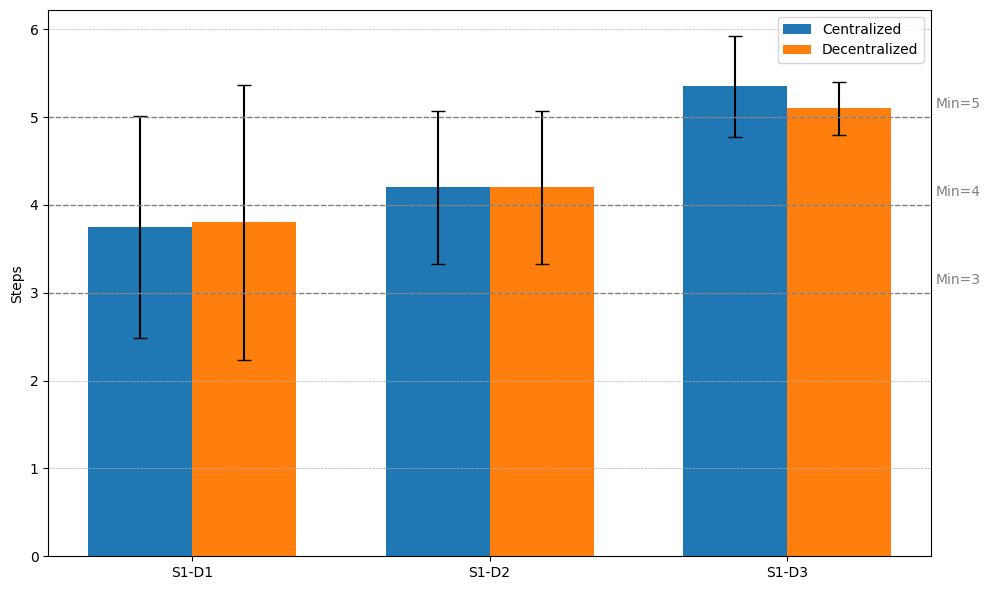

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data
centralized_optimal = np.array([3,4,3,3,3,4,4,3,5,3,4,3,6,8,3,3,4,3,3,3])
centralized_r2_pickplace = np.array([4]*19 + [8])
centralized_r2_inactive = np.array([5,7,5,5,6,5,5,6,5,5,5,5,5,6,5,5,6,5,5,6])

decentralized = np.array([3,3,3,8,8,3,3,3,3,3,5,5,3,3,5,3,3,3,3,3])
decentralized_r2_pickplace = np.array([4]*19 + [8])
decentralized_r2_inactive = np.array([5]*18 + [6]*2)

# Compute means and stds
means = [
    np.mean(centralized_optimal),
    np.mean(centralized_r2_pickplace),
    np.mean(centralized_r2_inactive),
    np.mean(decentralized),
    np.mean(decentralized_r2_pickplace),
    np.mean(decentralized_r2_inactive)
]
stds = [
    np.std(centralized_optimal),
    np.std(centralized_r2_pickplace),
    np.std(centralized_r2_inactive),
    np.std(decentralized),
    np.std(decentralized_r2_pickplace),
    np.std(decentralized_r2_inactive)
]

# Plot settings
labels = ['C-opt', 'C-R2PP', 'C-R2inactive', 'D-opt', 'D-R2PP', 'D-R2inactive']
x = np.arange(3)  # 3 scenarios
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Bar positions
bar1 = ax.bar(x - width/2, means[:3], width, yerr=stds[:3], capsize=5, label='Centralized')
bar2 = ax.bar(x + width/2, means[3:], width, yerr=stds[3:], capsize=5, label='Decentralized')

# Dashed lines for theoretical minimum steps
min_steps = [3, 4, 5]
for i, ms in enumerate(min_steps):
    ax.axhline(y=ms, color='gray', linestyle='--', linewidth=1)
    ax.text(2.5, ms + 0.1, f'Min={ms}', color='gray')

# Labels and styling
ax.set_ylabel('Steps')
# ax.set_title('Centralized vs. Decentralized Planner: Number of Steps during E')
ax.set_xticks(x)
ax.set_xticklabels(['S1-D1', 'S1-D2', 'S1-D3'])
ax.legend()
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


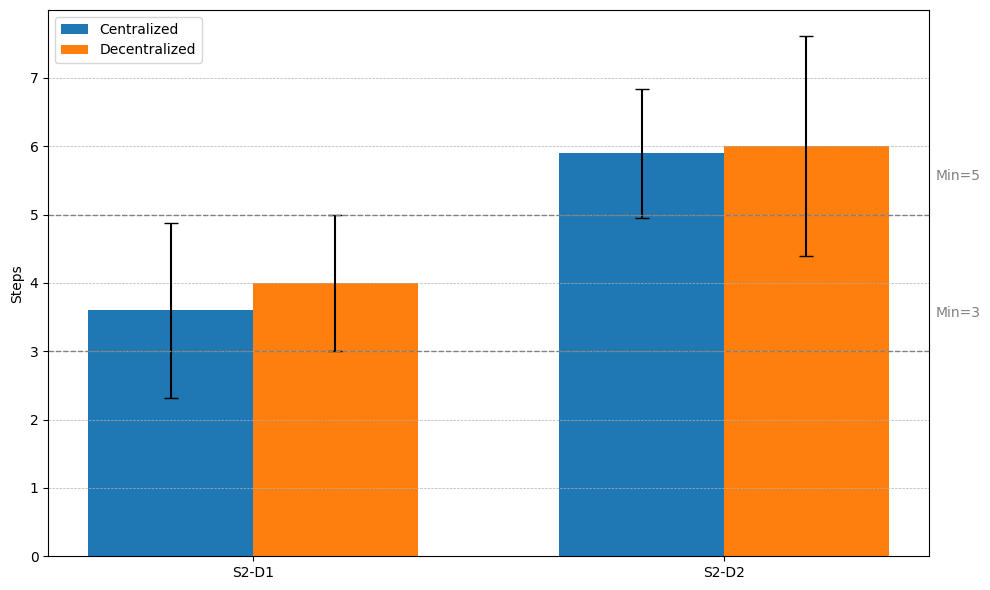

In [18]:

centralized_optimal_5 = np.array([5]*5 + [7]*4 + [6])
centralized_optimal_3 = np.array([3]*8 + [5, 7])
decentralized_5 = np.array([5,9,9,5,7,5,5,5,5,5])
decentralized_3 = np.array([3,5,3,3,5,3,5,5,5,3])

# Compute means and stds
means = [
    np.mean(centralized_optimal_3),
    np.mean(decentralized_3),
    np.mean(centralized_optimal_5),
    np.mean(decentralized_5),
    
]
stds = [
    np.std(centralized_optimal_3),
    np.std(decentralized_3),
    np.std(centralized_optimal_5),
    np.std(decentralized_5),
    
]

# Plot settings
x = np.arange(2)  # S2D1 and S2D2
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Bar positions
bar1 = ax.bar(x - width/2, [means[0], means[2]], width, yerr=[stds[0], stds[2]], capsize=5, label='Centralized')
bar2 = ax.bar(x + width/2, [means[1], means[3]], width, yerr=[stds[1], stds[3]], capsize=5, label='Decentralized')

# Dashed lines for theoretical minimum steps
min_steps = [5, 3]
for i, ms in enumerate(min_steps):
    ax.axhline(y=ms, color='gray', linestyle='--', linewidth=1)
    ax.text(1.45, ms + 0.5, f'Min={ms}', color='gray')
# for i, ms in enumerate(min_steps):
#     ax.axhline(y=ms, color='gray', linestyle='--', linewidth=1)
#     ax.text(x[i] + 0.1, ms + 0.1, f'Min={ms}', color='gray')

# Labels and styling
ax.set_ylabel('Steps')
ax.set_xticks(x)
ax.set_xticklabels(['S2-D1', 'S2-D2'])
ax.legend()
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

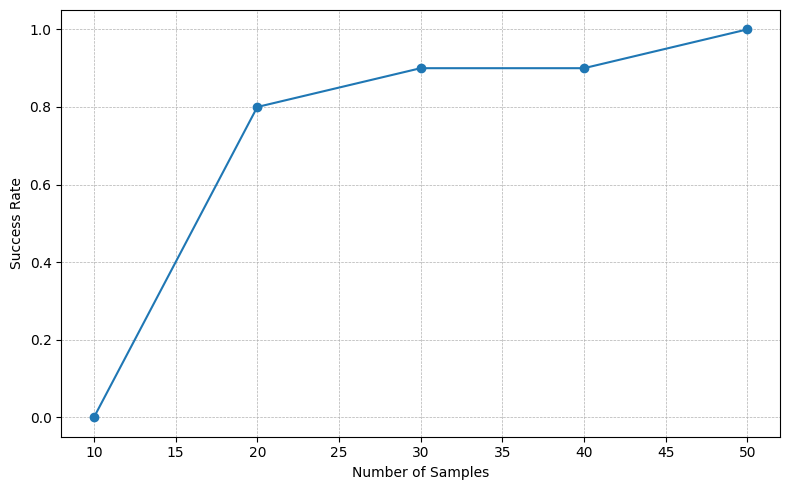

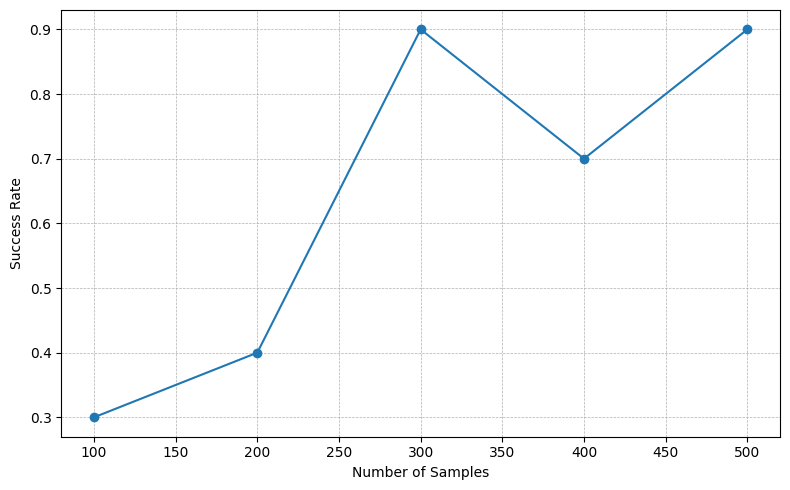

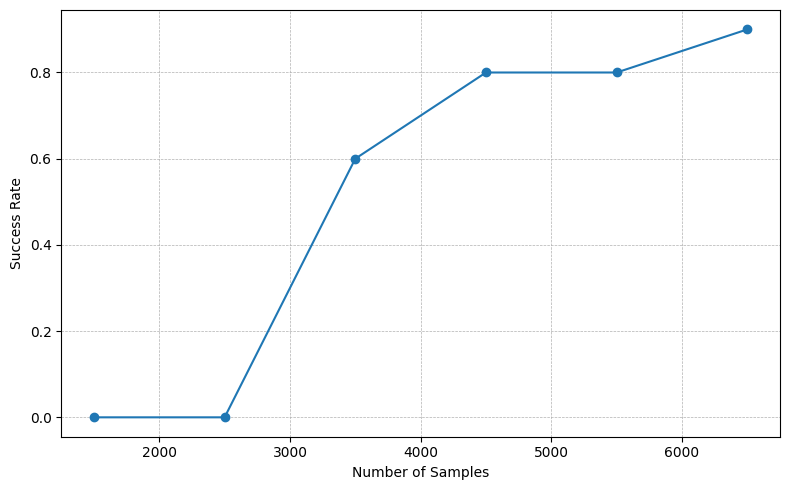

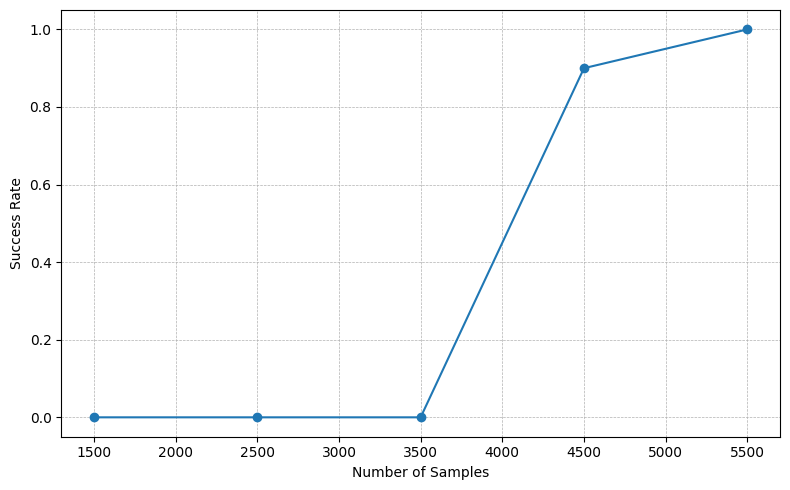

In [ ]:
import matplotlib.pyplot as plt

# Data
curves = {
    'D1': ([10, 20, 30, 40, 50], [0, 0.8, 0.9, 0.9, 1.0]),
    'D2': ([100, 200, 300, 400, 500], [0.3, 0.4, 0.9, 0.7, 0.9]),
    'D3': ([1500, 2500, 3500, 4500, 5500, 6500], [0, 0, 0.6, 0.8, 0.8, 0.9]),
    'D4': ([1500, 2500, 3500, 4500, 5500], [0, 0, 0, 0.9, 1.0])
}

# Plot each curve in a separate figure
for label, (x, y) in curves.items():
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='o')
    plt.xlabel('Number of Samples')
    plt.ylabel('Success Rate')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


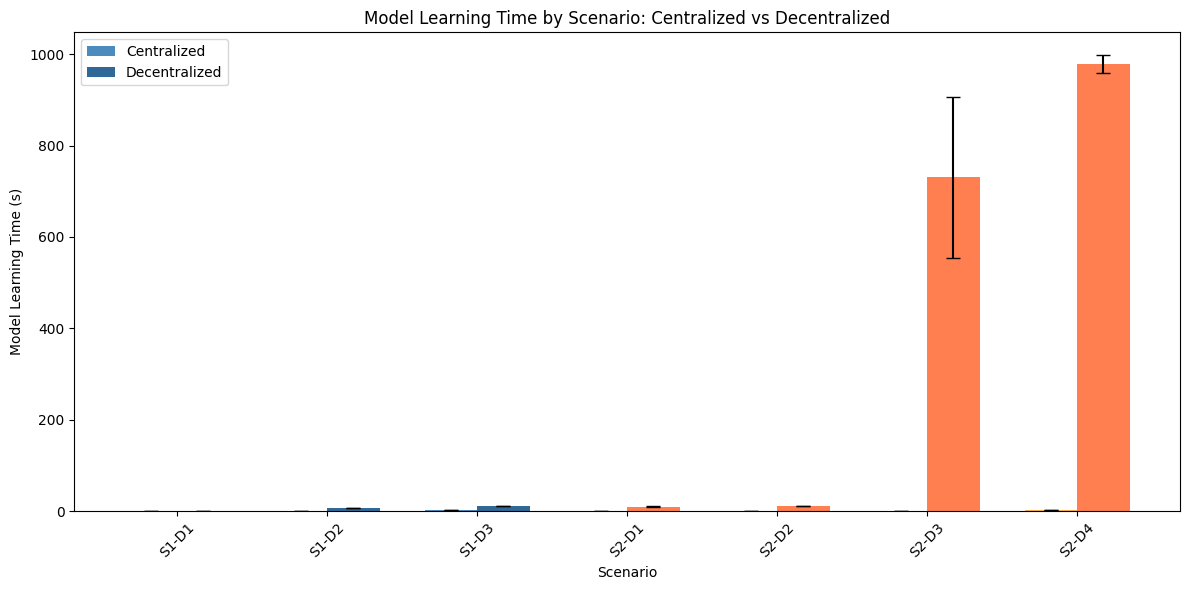

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Data
centralized = {
    "S1-D1": [0.56, 0.48, 0.63, 0.57, 0.56],
    "S1-D2": [0.52, 0.52, 0.52, 0.53, 0.47],
    "S1-D3": [2.26, 2.09, 2.13, 2, 2.08],
    "S2-D1": [0.61, 0.54, 0.58, 0.62, 0.54],
    "S2-D2": [0.61, 0.68, 0.7, 0.63, 0.64],
    "S2-D3": [0.69, 0.7, 0.67, 0.69, 0.75],
    "S2-D4": [2.78, 2.75, 2.45, 2.58, 2.53],
}

decentralized = {
    "S1-D1": [0.91, 0.76, 0.9, 0.85, 0.85],
    "S1-D2": [7.1, 6.8, 6.07, 6.42, 5.85],
    "S1-D3": [11.76, 10.45, 10.28, 10.28, 11],
    "S2-D1": [9.49, 9.89, 9.65, 9.58, 10.33],
    "S2-D2": [10.3, 10.14, 10.58, 10.8, 10.9],
    "S2-D3": [602.88, 607.25, 552.3, 950, 938.6],
    "S2-D4": [977.68, 1002.32, 953.92, 997.92, 961.84],
}

# Labels
scenarios = list(centralized.keys())
x = np.arange(len(scenarios))  # 7 positions
width = 0.35  # bar width

# Compute means and stds
def compute_stats(data_dict):
    means = [np.mean(data_dict[k]) for k in scenarios]
    stds = [np.std(data_dict[k]) for k in scenarios]
    return means, stds

mean_c, std_c = compute_stats(centralized)
mean_d, std_d = compute_stats(decentralized)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Colors: S1 = blue shades, S2 = orange shades
colors_c = ['#4B8BBE' if 'S1' in s else '#FFB347' for s in scenarios]
colors_d = ['#306998' if 'S1' in s else '#FF7F50' for s in scenarios]

# Plot bars
ax.bar(x - width/2, mean_c, width, yerr=std_c, label='Centralized', color=colors_c, capsize=5)
ax.bar(x + width/2, mean_d, width, yerr=std_d, label='Decentralized', color=colors_d, capsize=5)

# Labels and ticks
ax.set_ylabel('Model Learning Time (s)')
ax.set_xlabel('Scenario')
ax.set_title('Model Learning Time by Scenario: Centralized vs Decentralized')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


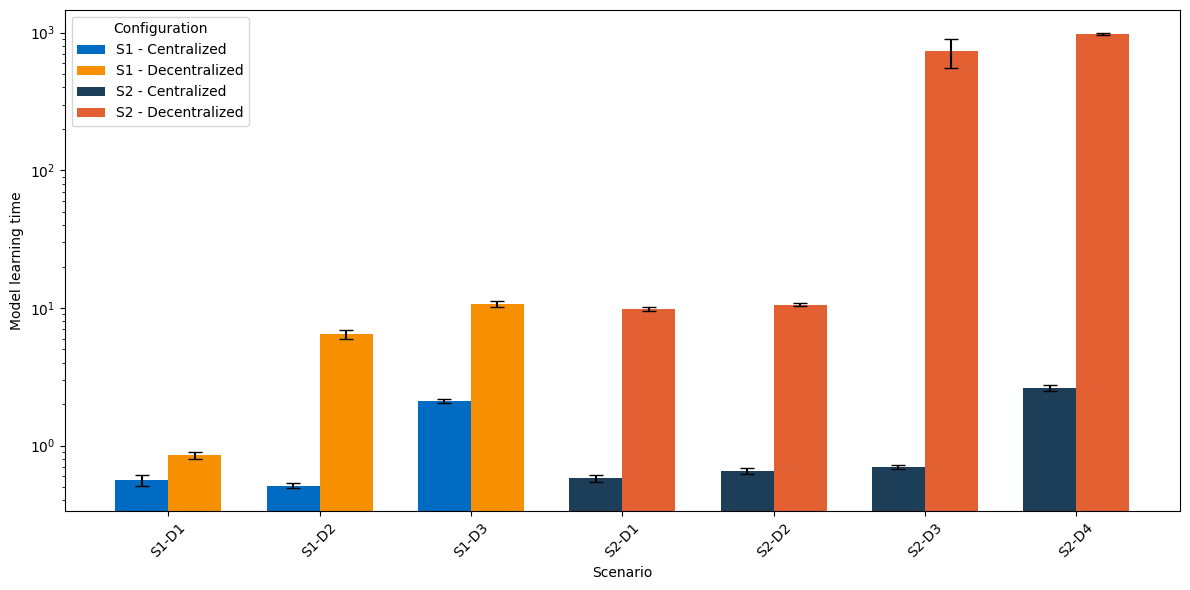

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Data
centralized = {
    "S1-D1": [0.56, 0.48, 0.63, 0.57, 0.56],
    "S1-D2": [0.52, 0.52, 0.52, 0.53, 0.47],
    "S1-D3": [2.26, 2.09, 2.13, 2, 2.08],
    "S2-D1": [0.61, 0.54, 0.58, 0.62, 0.54],
    "S2-D2": [0.61, 0.68, 0.7, 0.63, 0.64],
    "S2-D3": [0.69, 0.7, 0.67, 0.69, 0.75],
    "S2-D4": [2.78, 2.75, 2.45, 2.58, 2.53],
}

decentralized = {
    "S1-D1": [0.91, 0.76, 0.9, 0.85, 0.85],
    "S1-D2": [7.1, 6.8, 6.07, 6.42, 5.85],
    "S1-D3": [11.76, 10.45, 10.28, 10.28, 11],
    "S2-D1": [9.49, 9.89, 9.65, 9.58, 10.33],
    "S2-D2": [10.3, 10.14, 10.58, 10.8, 10.9],
    "S2-D3": [602.88, 607.25, 552.3, 950, 938.6],
    "S2-D4": [977.68, 1002.32, 953.92, 997.92, 961.84],
}

# Labels
scenarios = list(centralized.keys())
x = np.arange(len(scenarios))
width = 0.35

# Stats function
def compute_stats(data_dict):
    means = [np.mean(data_dict[k]) for k in scenarios]
    stds = [np.std(data_dict[k]) for k in scenarios]
    return means, stds

mean_c, std_c = compute_stats(centralized)
mean_d, std_d = compute_stats(decentralized)

# New color scheme: same hue, distinct shades
color_s1_centralized = "#006BC2"   # medium green
color_s1_decentralized = "#F79000" # darker green
color_s2_centralized = "#1D3E58"   # medium pink (hot pink)
color_s2_decentralized = "#E26031" # darker pink (deep magenta)


colors_c = [color_s1_centralized if 'S1' in s else color_s2_centralized for s in scenarios]
colors_d = [color_s1_decentralized if 'S1' in s else color_s2_decentralized for s in scenarios]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, mean_c, width, yerr=std_c, color=colors_c, capsize=5)
ax.bar(x + width/2, mean_d, width, yerr=std_d, color=colors_d, capsize=5)

# Log scale for y axis
ax.set_yscale('log')

# Axis labels
ax.set_ylabel('Model learning time')
ax.set_xlabel('Scenario')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45)

# Legend with updated colors
legend_elements = [
    Patch(facecolor=color_s1_centralized, label='S1 - Centralized'),
    Patch(facecolor=color_s1_decentralized, label='S1 - Decentralized'),
    Patch(facecolor=color_s2_centralized, label='S2 - Centralized'),
    Patch(facecolor=color_s2_decentralized, label='S2 - Decentralized'),
]
ax.legend(handles=legend_elements, title='Configuration')

plt.tight_layout()
plt.show()


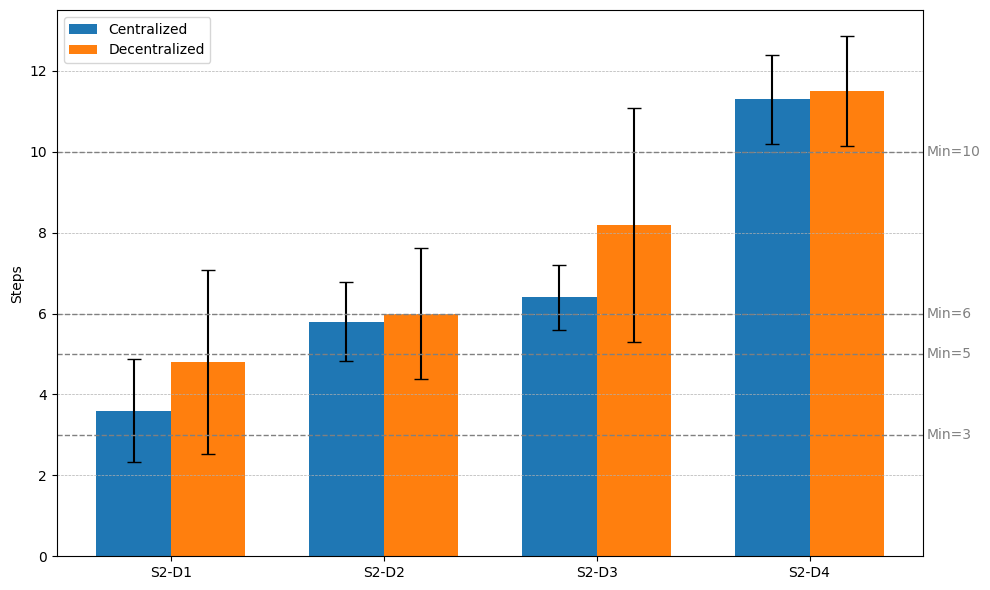

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Existing data
centralized_optimal_5 = np.array([5]*6 + [7]*4 )
centralized_optimal_3 = np.array([3]*8 + [5, 7])
decentralized_5 = np.array([5,9,9,5,7,5,5,5,5,5])
decentralized_3 = np.array([3,5,3,3,5,3,5,9,5,3])
decentralized_3 = np.array([3,3,3,3,3,5,5,5,9,9])

# New data for S2-D3
centralized_optimal_6 = np.array([6]*8 + [8]*2)
decentralized_6 = np.array([6,6,6,6,6,6,10,10,14,12])

# New data for S2-D4
centralized_optimal_10 = np.array([12,11,11,10,10,11,13,12,10,13])
decentralized_10 = np.array([12,10,11,10,10,13,14,13,11,11])

# Compute means and stds
means = [
    np.mean(centralized_optimal_3),
    np.mean(decentralized_3),
    np.mean(centralized_optimal_5),
    np.mean(decentralized_5),
    np.mean(centralized_optimal_6),
    np.mean(decentralized_6),
    np.mean(centralized_optimal_10),
    np.mean(decentralized_10),
]
stds = [
    np.std(centralized_optimal_3),
    np.std(decentralized_3),
    np.std(centralized_optimal_5),
    np.std(decentralized_5),
    np.std(centralized_optimal_6),
    np.std(decentralized_6),
    np.std(centralized_optimal_10),
    np.std(decentralized_10),
]

# Plot settings
x = np.arange(4)  # S2-D1, S2-D2, S2-D3, S2-D4
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Bar positions
bar1 = ax.bar(x - width/2, [means[i] for i in range(0, len(means), 2)],
              width, yerr=[stds[i] for i in range(0, len(stds), 2)],
              capsize=5, label='Centralized')
bar2 = ax.bar(x + width/2, [means[i] for i in range(1, len(means), 2)],
              width, yerr=[stds[i] for i in range(1, len(stds), 2)],
              capsize=5, label='Decentralized')

# Make room on the right for labels
fig.subplots_adjust(right=0.85)  # increase right margin

# Dashed lines for theoretical minimum steps (outside the plot area)
min_steps = [5, 3, 6, 10]
for ms in min_steps:
    ax.axhline(y=ms, color='gray', linestyle='--', linewidth=1)
    ax.text(len(x) - 0.45, ms, f'Min={ms}', color='gray',
            va='center', clip_on=False)

# Labels and styling
ax.set_ylabel('Steps')
ax.set_xticks(x)
ax.set_xticklabels(['S2-D1', 'S2-D2', 'S2-D3', 'S2-D4'])
ax.legend()
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
